In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [39]:
# Import et concaténation des deux fichiers source
path = "../Data/"
df_source1 = pd.read_csv(path + "Sleep_health_and_lifestyle_dataset.csv")
df_source2 = pd.read_csv(path + "Sleep_health_and_lifestyle_dataset_part_2.csv")
df = pd.concat([df_source1, df_source2])

# Person ID 374 est un doublon
df.drop(index=373, inplace=True)

# On retire l'ID du sujet qui ne nous sera pas utile
df.drop(columns="Person ID", inplace=True)

# On retire les doublons
df.drop_duplicates(inplace=True)

# On recréé l'index
df.index = np.arange(1,len(df)+1,1)

In [40]:
# Modification des noms de colonne, on supprime les espaces
mapper = {
    "Sleep Duration" : "SleepDuration",
    "Quality of Sleep" : "QualitySleep",
    "Physical Activity Level" : "PhysicalActivityLevel",
    "Stress Level" : "StressLevel",
    "BMI Category" : "BMI_Category",
    "Blood Pressure" : "BloodPressure",
    "Heart Rate" : "HeartRate",
    "Daily Steps" : "DailySteps",
    "Sleep Disorder" : "SleepDisorder"
}
df.rename(columns=mapper, inplace=True)

# On rectifie le type des variables (par défaut importées comme object)
new_types = {
    "Gender" : "string",
    "Occupation" : "string",
    "BMI_Category" : "string",
    "BloodPressure" : "string",
    "SleepDisorder" : "string"
}
df = df.astype(new_types)

In [41]:
#df
#plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/RL_CM3")

<Figure size 640x480 with 0 Axes>

In [42]:
# On sait qu'on n'a aucune valeur manquante pour SleepDisorder (None dans le fichier source)
# On crée une nouvelle catégorie pour les personnes sans trouble du sommeil
df.loc[df["SleepDisorder"].isna(), "SleepDisorder"] = "Healthy"

# On vérifie qu'on n'a aucune donnée manquante par ailleurs
df.isna().sum()

Gender                   0
Age                      0
Occupation               0
SleepDuration            0
QualitySleep             0
PhysicalActivityLevel    0
StressLevel              0
BMI_Category             0
BloodPressure            0
HeartRate                0
DailySteps               0
SleepDisorder            0
dtype: int64

In [43]:
# On a deux BMI_Category normales : "Normal Weight" et "Normal"
# On transforme les "Normal Weight" par "Normal"
df.replace("Normal Weight", "Normal", inplace=True)

# On sépare la tension en pression systolique et pression diastolique
for i in range(1,len(df)+1):
    pressure_list = df.loc[i,"BloodPressure"].split(sep='/')
    df.loc[i,"BloodPressureSystolic"] = int(pressure_list[0])
    df.loc[i,"BloodPressureDiastolic"] = int(pressure_list[1])
df.drop(columns="BloodPressure", inplace=True)

# On crée la liste des noms de variables quantitatives et qualitatives ordinales
quantitatives = ["Age", "SleepDuration", "PhysicalActivityLevel", "StressLevel", "QualitySleep",
                 "HeartRate", "DailySteps", "BloodPressureSystolic", "BloodPressureDiastolic"]

# On prépare une nouvelle colonne binaire pour les sujets sains et qui présentent un trouble du sommeil
encoding = {"Healthy": "Healthy", "Insomnia": "Unhealthy", "Sleep Apnea": "Unhealthy"} # 3 labels : sain, insomnie, apnée du sommeil
df["HasSleepDisorder"] = df["SleepDisorder"].map(encoding)

In [34]:
import dataframe_image as dfi

dfi.export(df.iloc[:10,:],"C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/df_nettoyé.png")
#plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/describe")

In [33]:
df

,Gender,Age,Occupation,SleepDuration,QualitySleep,PhysicalActivityLevel,StressLevel,BMI_Category,HeartRate,DailySteps,SleepDisorder,BloodPressureSystolic,BloodPressureDiastolic,HasSleepDisorder
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,Healthy,126.0,83.0,Healthy
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,Healthy,125.0,80.0,Healthy
3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,Healthy,125.0,80.0,Healthy
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140.0,90.0,Unhealthy
5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140.0,90.0,Unhealthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,Female,43,Teacher,6.7,7,45,4,Overweight,65,6000,Insomnia,135.0,90.0,Unhealthy
556,Male,43,Salesperson,6.5,6,45,7,Overweight,72,6000,Insomnia,130.0,85.0,Unhealthy
557,Female,43,Teacher,6.7,7,45,4,Overweight,65,6000,Insomnia,135.0,90.0,Unhealthy
558,Male,43,Salesperson,6.4,6,45,7,Overweight,72,6000,Insomnia,130.0,85.0,Unhealthy


In [119]:
for col in ['Gender', 'Occupation', 'BMI_Category', 'SleepDisorder', 'DailySteps']:
    print(f"\nOccurrences pour {col} :\n")
    print(df[col].value_counts())


Occurrences pour Gender :

Gender
Male      67
Female    65
Name: count, dtype: Int64

Occurrences pour Occupation :

Occupation
Nurse                   29
Doctor                  24
Engineer                22
Teacher                 15
Lawyer                  15
Accountant              11
Salesperson              9
Software Engineer        3
Scientist                2
Sales Representative     1
Manager                  1
Name: count, dtype: Int64

Occurrences pour BMI_Category :

BMI_Category
Normal        73
Overweight    52
Obese          7
Name: count, dtype: Int64

Occurrences pour SleepDisorder :

SleepDisorder
Healthy        73
Sleep Apnea    30
Insomnia       29
Name: count, dtype: Int64

Occurrences pour DailySteps :

DailySteps
8000     32
6000     20
5000     20
7000     20
10000    13
5500      3
4000      3
6800      3
4800      2
3300      2
4200      2
4100      2
3500      2
3000      2
5200      1
5600      1
7500      1
7300      1
6200      1
3700      1
Name: count

In [120]:
for col in df:
    print(df[col].unique())

<StringArray>
['Male', 'Female']
Length: 2, dtype: string
[27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 48 49 50 51 52
 53 54 55 56 57 58 59]
<StringArray>
[   'Software Engineer',               'Doctor', 'Sales Representative',
              'Teacher',                'Nurse',             'Engineer',
           'Accountant',            'Scientist',               'Lawyer',
          'Salesperson',              'Manager']
Length: 11, dtype: string
[6.1 6.2 5.9 6.3 7.8 6.  6.5 7.6 7.7 7.9 6.4 7.5 7.2 5.8 6.7 7.3 7.4 7.1
 6.6 6.9 8.  6.8 8.1 8.3 8.5 8.4 8.2]
[6 4 7 5 8 9]
[42 60 30 40 75 35 45 50 32 70 80 55 90 47 65 85]
[6 8 7 4 3 5]
<StringArray>
['Overweight', 'Normal', 'Obese']
Length: 3, dtype: string
[77 75 85 82 70 80 78 69 72 68 76 81 65 84 74 67 73 83 86]
[ 4200 10000  3000  3500  8000  4000  4100  6800  5000  7000  5500  5200
  5600  3300  4800  7500  7300  6200  6000  3700]
<StringArray>
['Healthy', 'Sleep Apnea', 'Insomnia']
Length: 3, dtype: string
[126. 125. 140. 

<Axes: xlabel='SleepDisorder', ylabel='StressLevel'>

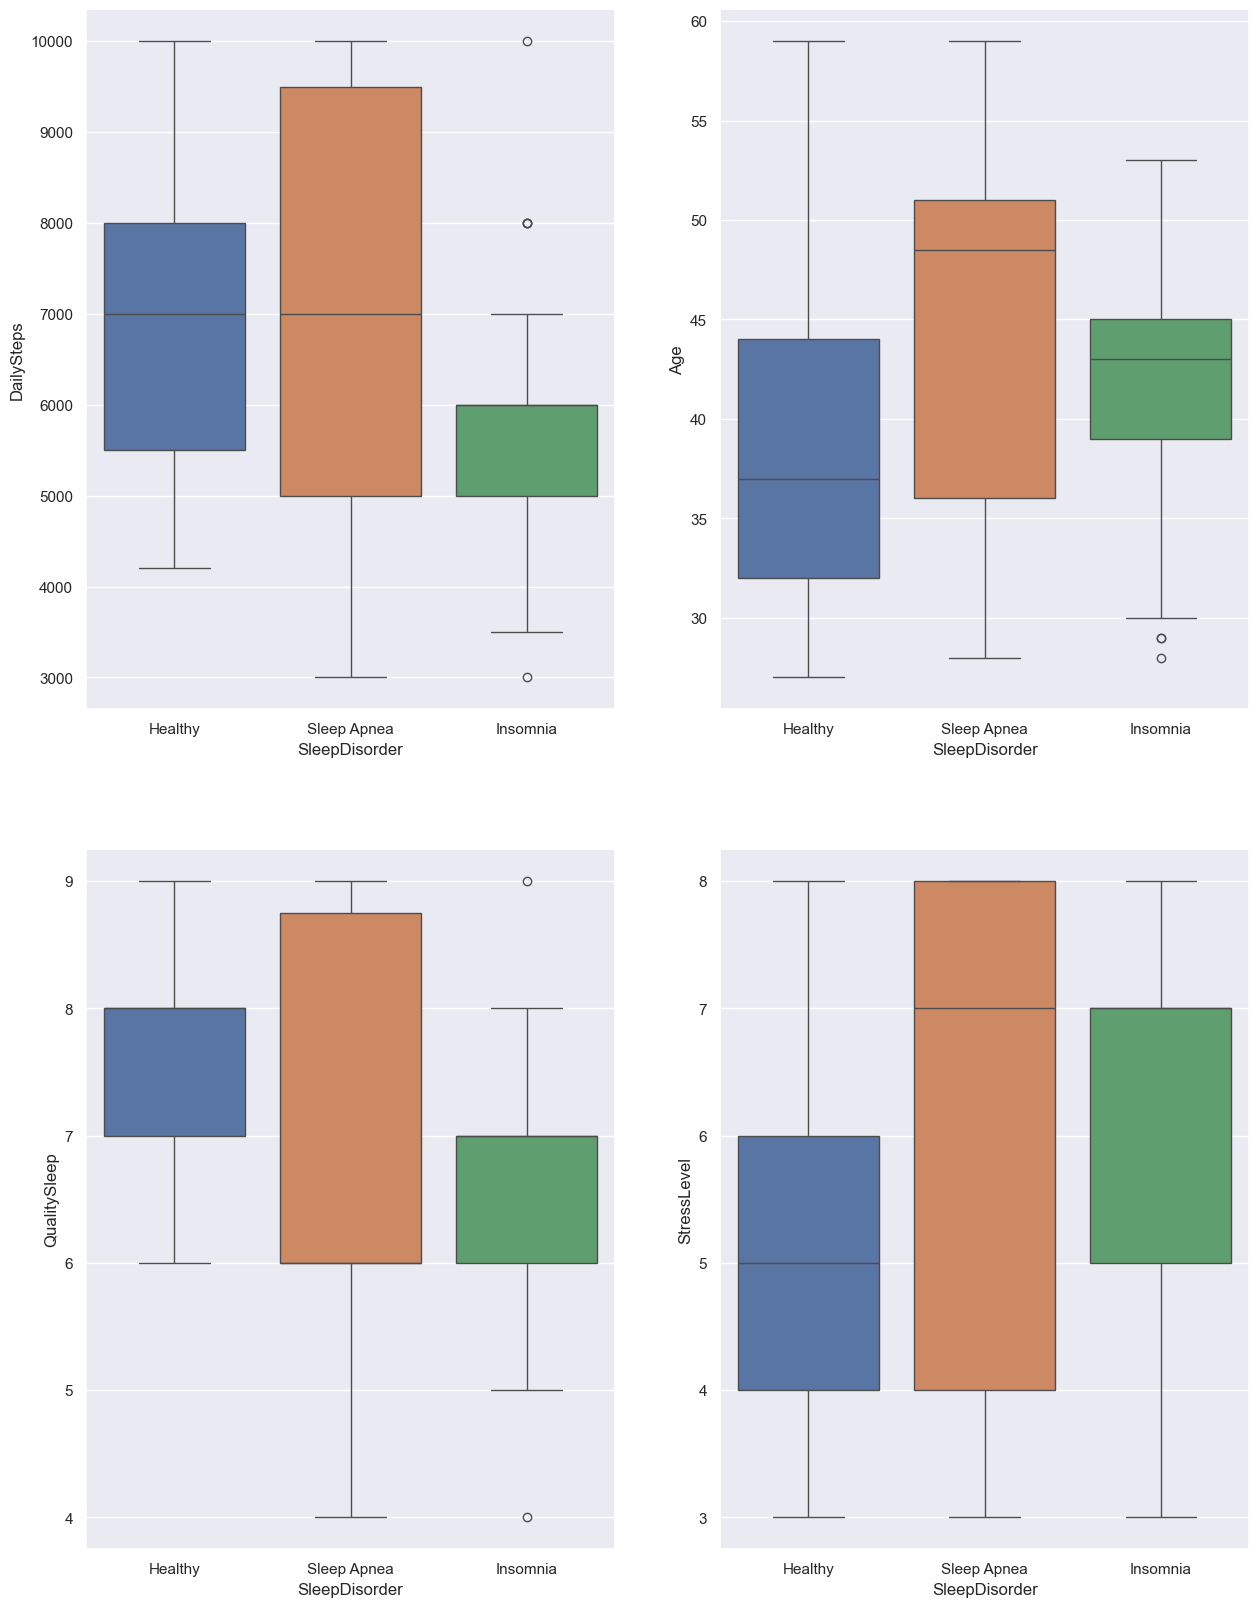

In [121]:
#BOXPLOT
sns.set_theme()

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_figheight(20)
fig.set_figwidth(15)

BMI_order = ["Normal","Overweight","Obese"]
#sns.boxplot(data = df, x = 'Gender', y = "Age",hue = "Gender",palette="Pastel1", ax=axs[0][0])
#sns.boxplot(data = df, x = 'Gender', y = "QualitySleep",hue = "Gender",palette="Pastel1", ax=axs[0][1])
#sns.boxplot(data = df, x = 'BMI_Category', y = "PhysicalActivityLevel",hue = "BMI_Category",order=BMI_order,palette="Pastel1", ax=axs[1][0]) #Important, pour montrer que les données sont cohérentes qd même
#sns.boxplot(data = df, x = 'BMI_Category', y = "QualitySleep",hue = "BMI_Category",order=BMI_order,palette="Pastel1", ax=axs[1][1]) #Important, pour montrer que les données sont cohérentes qd même
#plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/boxplot1")
sns.boxplot(data = df, x = 'SleepDisorder', y = "DailySteps",hue = "SleepDisorder", ax=axs[0][0]) #Important
sns.boxplot(data = df, x = 'SleepDisorder', y = "Age",hue = "SleepDisorder", ax=axs[0][1]) #Important
sns.boxplot(data = df, x = 'SleepDisorder', y = "QualitySleep",hue = "SleepDisorder", ax=axs[1][0])
sns.boxplot(data = df, x = 'SleepDisorder', y = "StressLevel",hue = "SleepDisorder", ax=axs[1][1]) #Important
#plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/boxplot2")

<Axes: xlabel='SleepDisorder', ylabel='Count'>

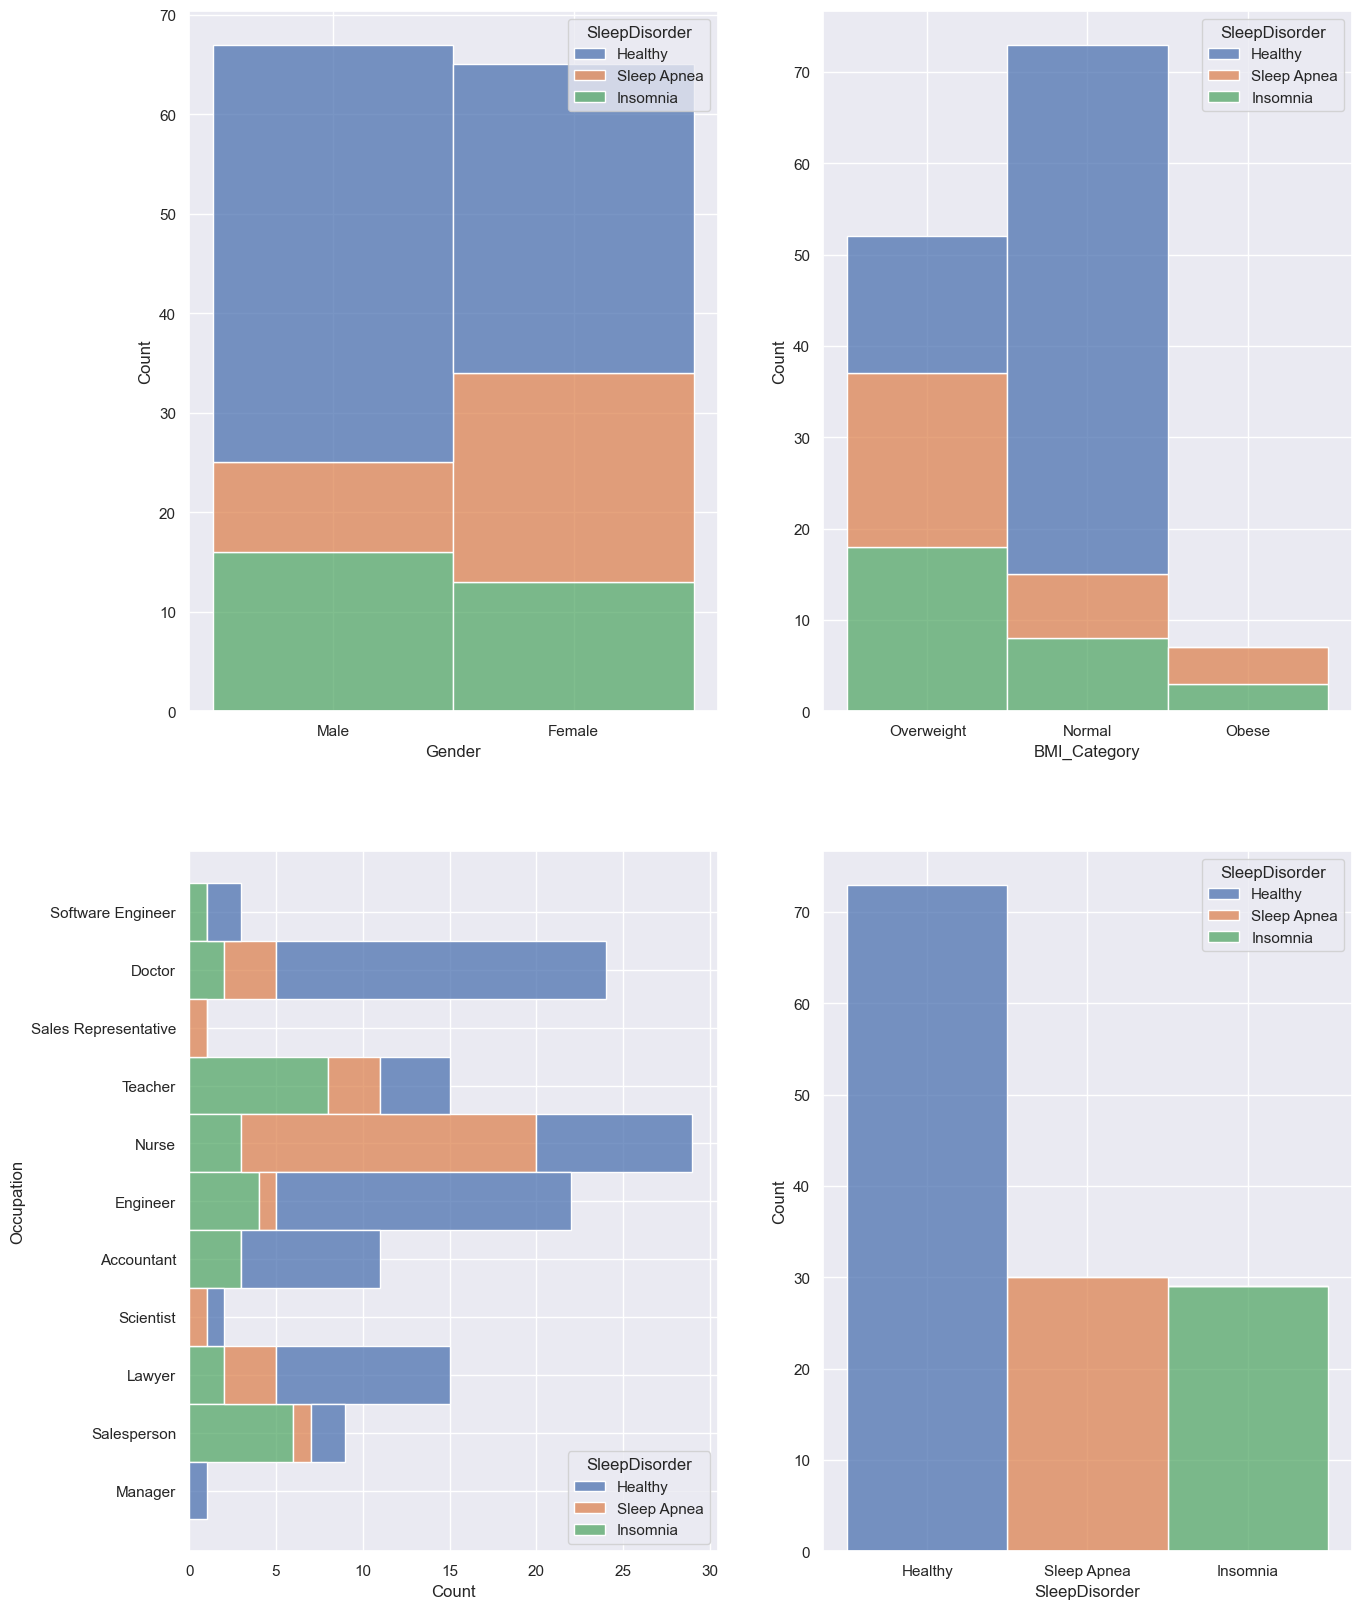

In [122]:
#HISTOGRAMMES
sns.set_theme()

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_figheight(20)
fig.set_figwidth(15)
#Histogrammes pour les variables catégorielles car dans le pairplot on aura tous les histogrammes des variables quantitavives
sns.histplot(data = df, x = "Gender",hue = "SleepDisorder",multiple = "stack",ax =axs[0][0]) 
sns.histplot(data = df, x = "BMI_Category",hue = "SleepDisorder",multiple = "stack", ax =axs[0][1])
sns.histplot(data = df, y = "Occupation",hue = "SleepDisorder",multiple = "stack", ax =axs[1][0])
sns.histplot(data = df, x = "SleepDisorder",hue = "SleepDisorder",multiple = "stack", ax =axs[1][1])
#plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/histogramme")

In [123]:
# On crée la matrice des corrélation pour les variables quantitatives et qualitatives ordinales
#sns.heatmap(df[quantitatives].corr(), annot=True, cmap="RdBu_r")
#plt.title("Matrice des corrélations")
#plt.show()
# plt.savefig()

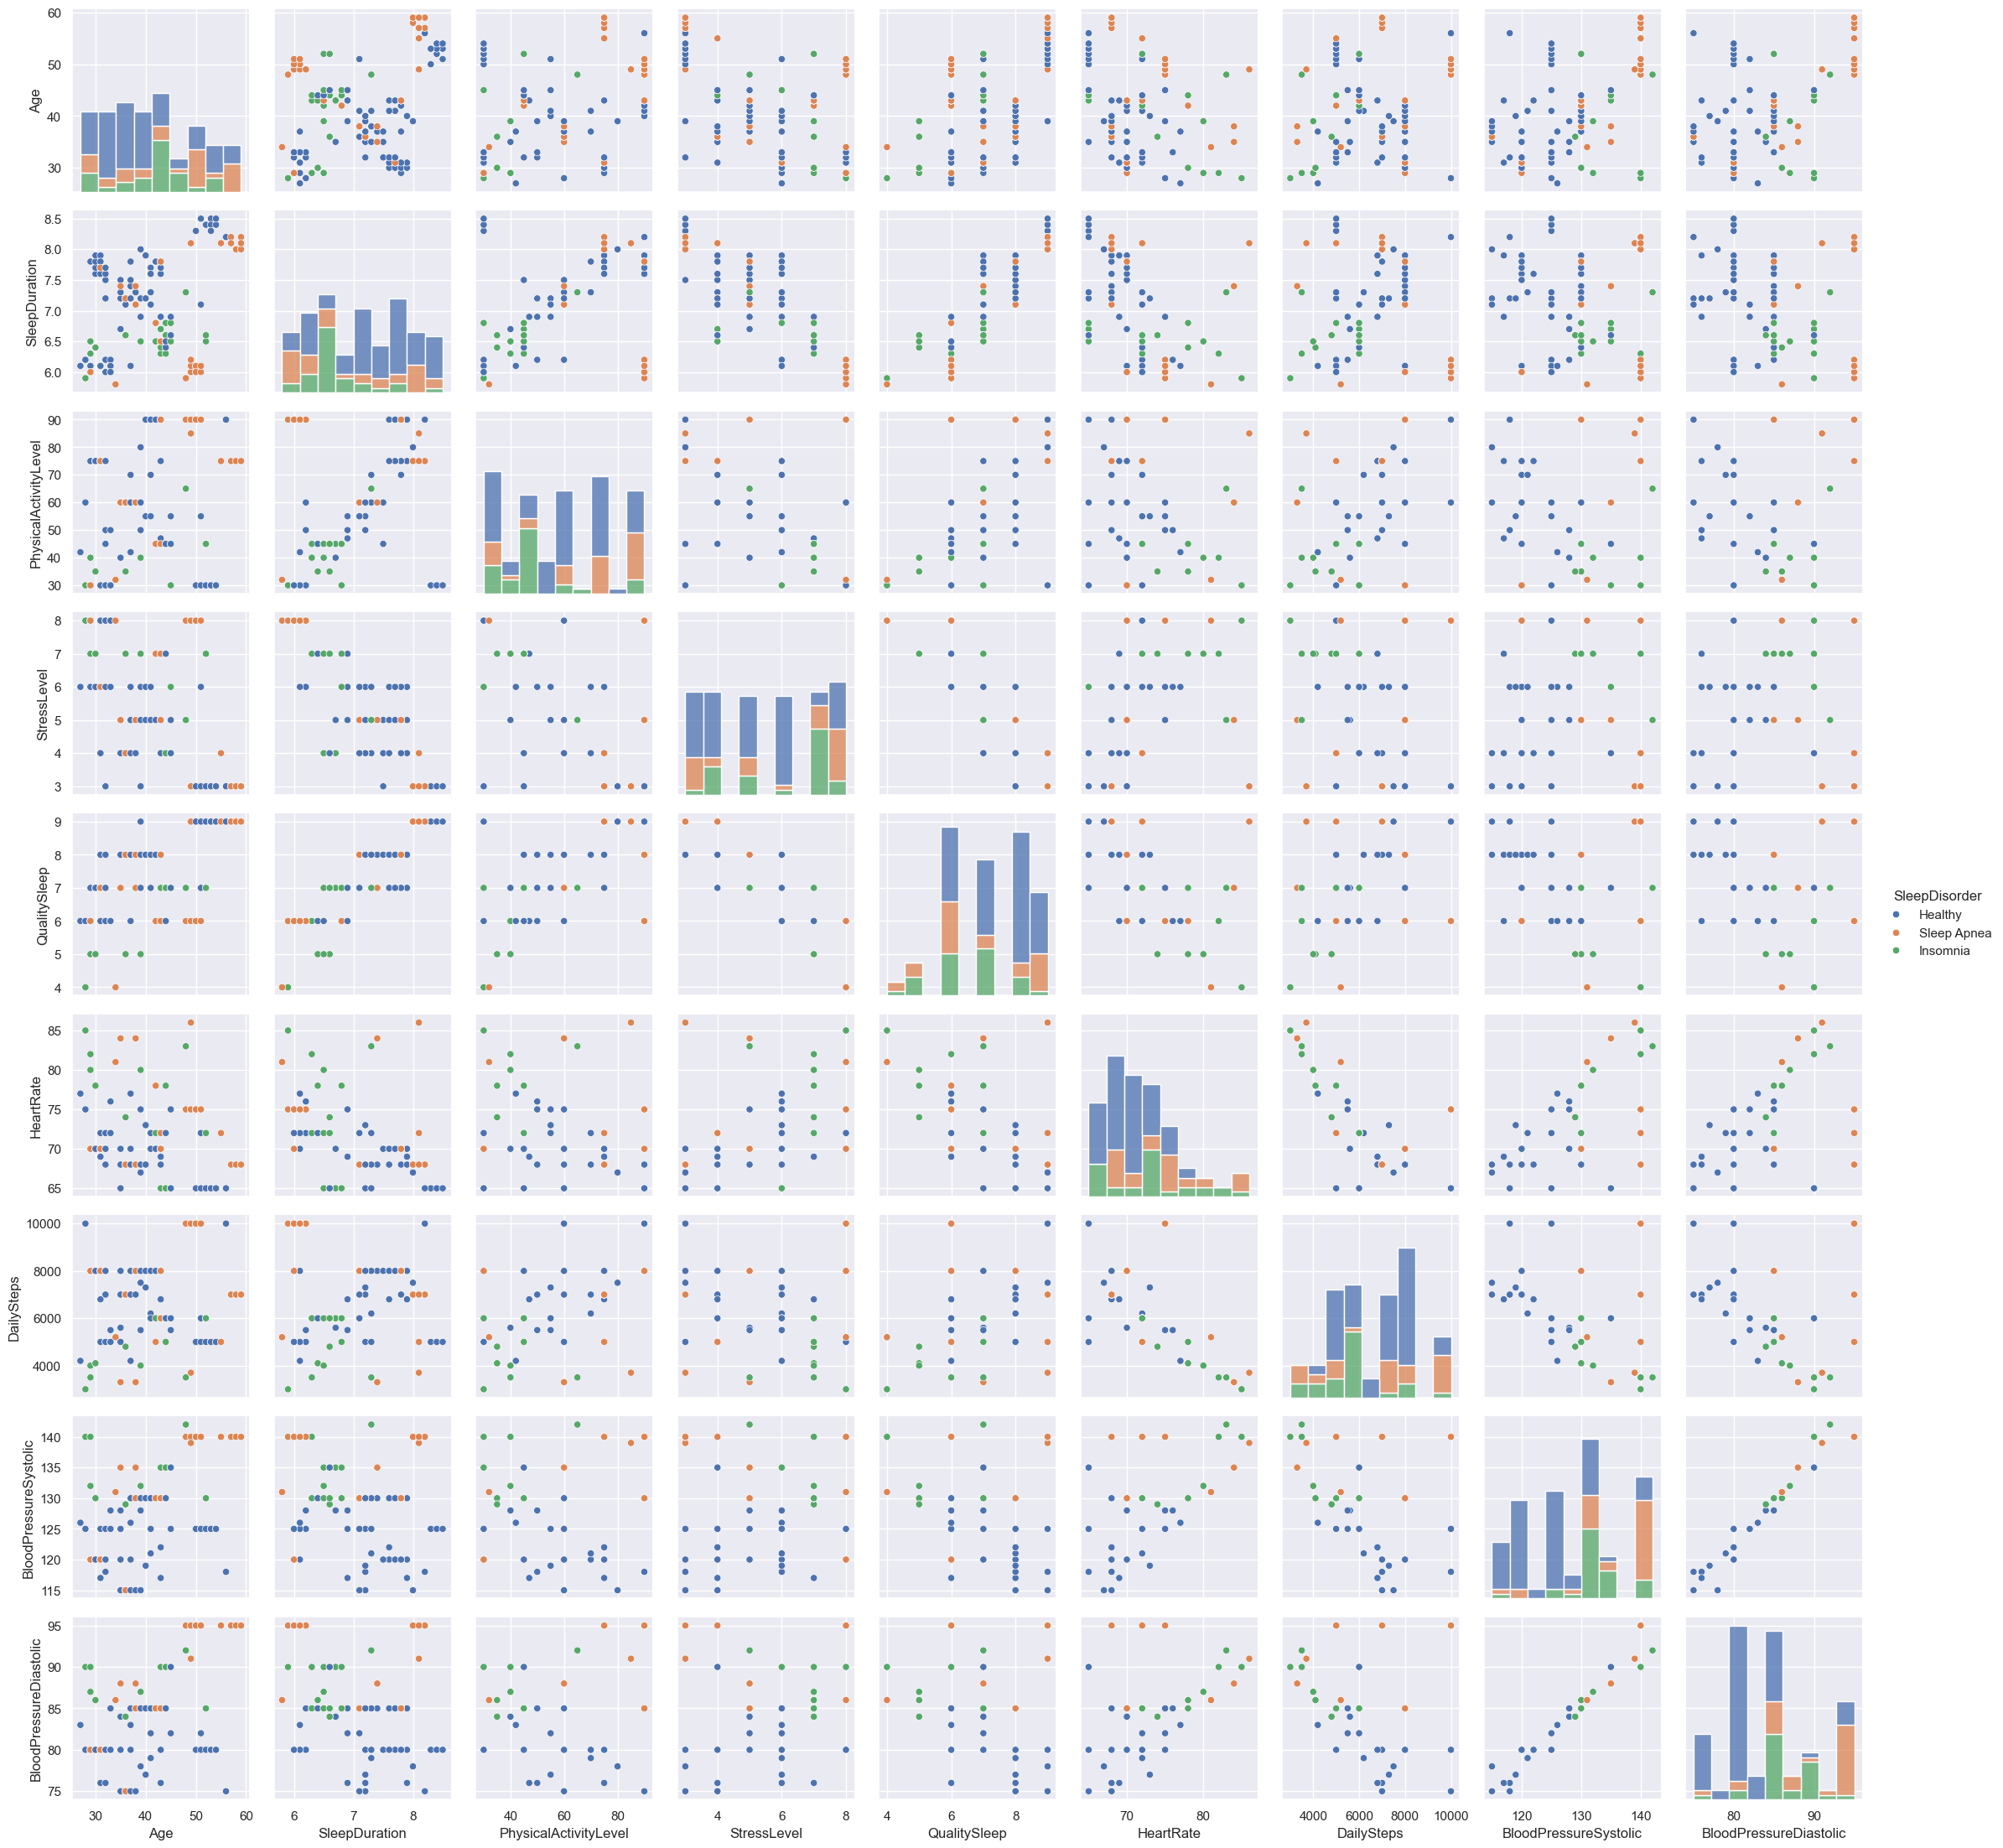

In [124]:
sns.set_theme()
g = sns.PairGrid(df[quantitatives+["SleepDisorder"]], hue="SleepDisorder")
g.map_diag(sns.histplot, multiple="stack")
g.map_offdiag(sns.scatterplot)
g.add_legend()
#plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/pairplot")
plt.show()

In [44]:
class mm_scaler:
    def __init__(self):
        self.grades = None
        self.quantitatives = None
        self.mini = {}
        self.maxi = {}

    def fit(self, data, quantitatives, grades):
        self.grades = grades
        self.quantitatives = quantitatives

        for column in quantitatives:
            self.mini[column] = min(data[column])*0.9
            self.maxi[column] = max(data[column])*1.1
        
    def transform(self, data):
        df_copy = data.copy()

        # On scale les colonnes quantitatives
        for column in self.quantitatives:
            df_copy[column] = (df_copy[column] - self.mini[column]) / \
                              (self.maxi[column]-self.mini[column])
        
        # On scale les notes
        df_copy[self.grades] = df_copy[self.grades]/10
        
        return df_copy
    
    def transform_inverse(self, data):
        df_copy = data.copy()

        # On retransforme les données quantitatives
        for column in self.quantitatives:
            df_copy[column] = df_copy[column]*(self.maxi[column]-self.mini[column]) + \
                              self.mini[column]
        
        # On retransforme les notes
        df_copy[self.grades] = df_copy[self.grades]*10
        
        return df_copy
    

In [45]:
# Encodage de la variable à expliquer SleepDisorder
encoding = {"Healthy": 0, "Insomnia": 1, "Sleep Apnea": 2} # 3 labels : sain, insomnie, apnée du sommeil
df["SleepDisorderEncoded"] = df["SleepDisorder"].map(encoding)
encoding = {"Healthy": 0, "Insomnia": 1, "Sleep Apnea": 1} # 2 labels : avec vs sans trouble
df["HasSleepDisorder"] = df["SleepDisorder"].map(encoding)
df.drop(columns="SleepDisorder", inplace=True)

# Encodage des variables catégorielles
def OneHot(df, columns, except_one=False):
    '''
    One Hot Encoding pour une variable catégorielle.
    '''
    if except_one:
        for column in columns:
            for iter in df[column].unique()[:-1]:
                name = iter.replace(" ", "")
                df[name] = 0
                df.loc[df[column]==iter,name] = 1
    else:
        for column in columns:
            for iter in df[column].unique():
                name = iter.replace(" ", "")
                df[name] = 0
                df.loc[df[column]==iter,name] = 1
        
    df = df.drop(columns=columns, inplace=False)

    return df

df_all_encoded = OneHot(df, ["Gender", "Occupation", "BMI_Category"])
df_minimal_encoded = OneHot(df, ["Gender", "Occupation", "BMI_Category"], except_one=True)

# Découpage en train/test
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_all_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"]), 
                                                    df_all_encoded[["SleepDisorderEncoded","HasSleepDisorder"]], random_state=42,
                                                    stratify=df["SleepDisorderEncoded"])

X_train_minimal, X_test_minimal, y_train_minimal, y_test_minimal = train_test_split(df_minimal_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"]), 
                                                    df_minimal_encoded[["SleepDisorderEncoded","HasSleepDisorder"]], random_state=42,
                                                    stratify=df_minimal_encoded["SleepDisorderEncoded"])

# Full set notamment pour entraîner la forêt 
X_full_set_all = df_all_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"])
Y_full_set_all = df_all_encoded[["SleepDisorderEncoded","HasSleepDisorder"]]
X_full_set_minimal = df_minimal_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"])
Y_full_set_minimal = df_minimal_encoded[["SleepDisorderEncoded","HasSleepDisorder"]]

In [46]:
def Matrice_ROC_Var(model):
    model = model
    pred_train = model.predict(X_train_all)

    # Calculer un array de proba de prédiction pour la classe 1 et mettre un seuil pour customiser le modèle
    y_prob = model.predict_proba(X_test_all)[:, 1]
    pred_test = (y_prob > 0.5).astype(int)
    print("Acccuracy : ", len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))

    # Matrice de confusion
    cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
    
    # Créer subplot pour la Matrice de Confusion et la courbe ROC 
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plotter Matrice de Confusion
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title("Matrice de Confusion")

    # Générer un courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test_all["HasSleepDisorder"], y_prob)

    # Computer Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")

    # Plot la courbe ROC
    axes[1].plot(fpr, tpr, color="blue", lw=2, label=f"Courbe ROC (AUC = {roc_auc:.2f})")
    axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1.5, label="Pile ou Face")
    axes[1].set_title("Courbe ROC")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend(loc="lower right")
    axes[1].grid(True)

    
    # Extraire les features importances
    feature_importances = model.feature_importances_

    # Create a DataFrame for feature importances
    features = pd.DataFrame({
        'Feature': X_train_all.columns,
        'Importance': feature_importances
    })

    # Selectionner le top 10 features les plus importants
    top_features = features.sort_values(by='Importance', ascending=False).head(10)

    # Plot les 10 features plus importants
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_r')
    plt.title('Top 10 Variables Importantes')
    plt.xlabel('Variables Importantes')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [47]:
my_scaler = mm_scaler()
quantitatives_bis = [item for item in quantitatives if item not in ["QualitySleep", "StressLevel"]]
my_scaler.fit(X_train_all,quantitatives_bis, ["QualitySleep", "StressLevel"])
X_train_all_scaled = my_scaler.transform(X_train_all)

my_scaler2 = mm_scaler()
quantitatives_bis = [item for item in quantitatives if item not in ["QualitySleep", "StressLevel"]]
my_scaler2.fit(X_train_minimal,quantitatives_bis, ["QualitySleep", "StressLevel"])
X_train_minimal_scaled = my_scaler2.transform(X_train_minimal)

0.8484848484848485
0.7878787878787878


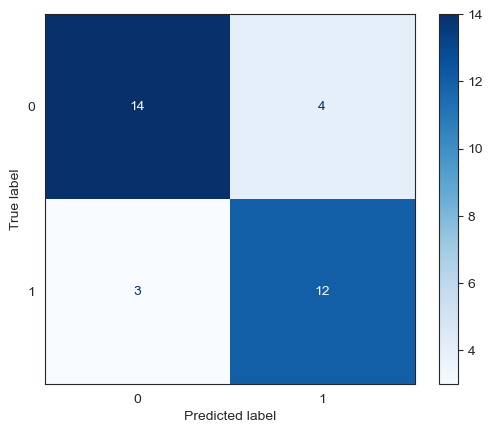

In [50]:
# On essaie que linéaire, beaucoup de variables catégorielles, les autres moins pertinentes
# Le problème est presque linéairement séparable car on obtient de bons résultats juste avec un noyau linéaire
sns.set_style("white")
SVM_HAS = SVC(kernel="linear", max_iter=-1,C=3, random_state=42).fit(X_train_all_scaled.drop(columns=["BloodPressureDiastolic"]), y_train_minimal["HasSleepDisorder"])
pred_train = SVM_HAS.predict(X_train_all_scaled.drop(columns=["BloodPressureDiastolic"]))
pred_test = SVM_HAS.predict(my_scaler.transform(X_test_all).drop(columns = ["BloodPressureDiastolic"]))
print(len(y_train_all[y_train_all["HasSleepDisorder"]==pred_train])/len(y_train_all))
print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/SVM_CM3")

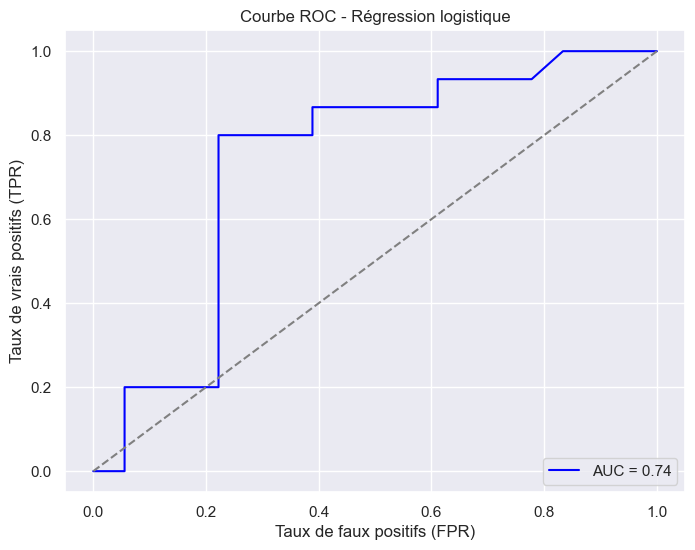

ValueError: All arrays must be of the same length

In [186]:
y_scores = RL.decision_function(my_scaler.transform(X_test_all))

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_all["HasSleepDisorder"], y_scores)
auc = roc_auc_score(y_test_all["HasSleepDisorder"], y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Régression logistique')
plt.legend(loc='lower right')
plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/RL_ROC")
plt.show()

# Extraire l'importance des features (coefficients du SVM)
feature_importance = pd.DataFrame({
    'Feature': X_train_all_scaled.columns,
    'Importance': np.abs(SVM_HAS.coef_[0])  # Importance = valeur absolue des coefficients
})

# Trier par importance décroissante
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)

# Afficher le top 10 des features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance des caractéristiques')
plt.title('Top 10 des Features Importance - SVM linéaire')
plt.gca().invert_yaxis()  # Inversion pour afficher la plus importante en haut
plt.show()

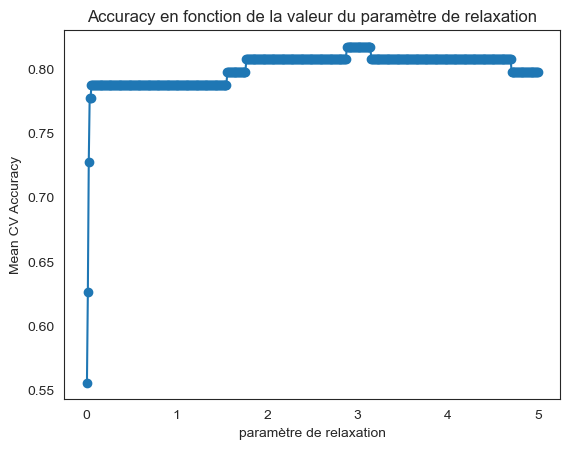

In [58]:
# On définit l'ensemble des valeurs à tester pour le paramètre
relaxation = np.arange(0.01,5,0.01)

# Stockage des scores
cv_scores = []

# On fait une validation croisée pour chaque valeur du paramètre
for relax in relaxation:
    clf = SVC(kernel="linear", C=relax, max_iter=-1, random_state=42).fit(X_train_all_scaled.drop(columns=["BloodPressureDiastolic"]), y_train_minimal["HasSleepDisorder"])
    # On calcule le score de validation moyen : accuracy
    scores = cross_val_score(clf, X_train_all_scaled.drop(columns=["BloodPressureDiastolic"]), y_train_all["HasSleepDisorder"], cv=5)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)

# On plot le score moyen contre les valeurs du paramètre
plt.plot(relaxation, cv_scores, marker='o')
plt.xlabel('paramètre de relaxation')
plt.ylabel('Mean CV Accuracy')
plt.title('Accuracy en fonction de la valeur du paramètre de relaxation')
plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/SVM relaxation")
plt.show()



In [138]:
cv_scores.argmax()

AttributeError: 'list' object has no attribute 'argmax'

0.7878787878787878


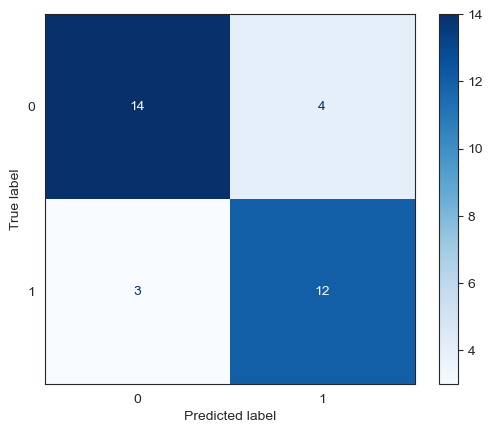

In [62]:
RL = LogisticRegression(C=1.62, solver="lbfgs", penalty="l2",max_iter=100000, random_state=42)
RL.fit(X_train_all_scaled, y_train_all["HasSleepDisorder"])

# Prédictions sur le jeu d'entraînement
pred_test = RL.predict(my_scaler.transform(X_test_all))

y_prob = RL.predict_proba(my_scaler.transform(X_test_all))[:, 1]  # Probabilités pour la classe positive

# Ajuster le seuil à un niveau plus élevé (par exemple, 0.3)
threshold = 0.5
pred_test_adjusted = (y_prob >= threshold).astype(int)
sns.set_style("white")

# Évaluation sur le jeu d'entraînement
print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test_adjusted])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test_adjusted)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/RL_CM3")

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

# Définition de la grille d'hyperparamètres
param_grid = {
    'C': np.logspace(-4, 4, 20),  # C sur une échelle logarithmique de 0.0001 à 10000
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'penalty': ['l1', 'l2'],  # ElasticNet peut aussi être ajouté si nécessaire
    'max_iter': [10000, 50000, 100000]  # Pour s'assurer de la convergence
}

# Modèle de base
RL = LogisticRegression(random_state=42)

# Grid Search avec validation croisée
grid_search = GridSearchCV(RL, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_all_scaled, y_train_all["HasSleepDisorder"])

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Entraînement du modèle avec les meilleurs hyperparamètres
best_RL = grid_search.best_estimator_

# Prédictions
pred_test = best_RL.predict(my_scaler.transform(X_test_all))

# Calcul des probabilités pour ajuster le seuil
y_prob = best_RL.predict_proba(my_scaler.transform(X_test_all))[:, 1]

# Ajustement du seuil
threshold = 0.5
pred_test_adjusted = (y_prob >= threshold).astype(int)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Meilleurs hyperparamètres : {'C': 1.623776739188721, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
300 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _

Acccuracy :  0.5454545454545454


TypeError: 'numpy.float64' object is not callable

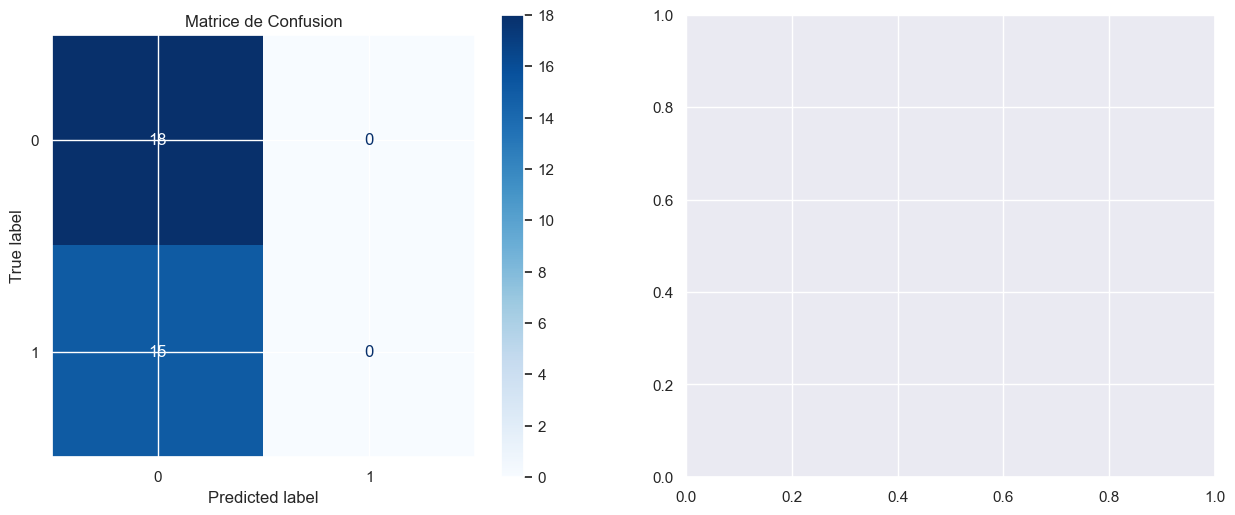

In [183]:
Matrice_ROC_Var(RL)

In [178]:
# Grille de paramètres
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg']
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=RL,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Utilisation de tous les cœurs pour accélérer
)

# Entraînement
grid_search.fit(X_train_all, y_train_all["HasSleepDisorder"])

# Résultats
print("Best Parameters:", grid_search.best_params_)
print("Best accuracy", grid_search.best_score_)

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Best accuracy 0.8173684210526314


C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
175 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _ch

In [57]:
list(df.columns)

['Gender',
 'Age',
 'Occupation',
 'SleepDuration',
 'QualitySleep',
 'PhysicalActivityLevel',
 'StressLevel',
 'BMI_Category',
 'HeartRate',
 'DailySteps',
 'BloodPressureSystolic',
 'BloodPressureDiastolic',
 'HasSleepDisorder',
 'SleepDisorderEncoded',
 'Male',
 'Female',
 'SoftwareEngineer',
 'Doctor',
 'SalesRepresentative',
 'Teacher',
 'Nurse',
 'Engineer',
 'Accountant',
 'Scientist',
 'Lawyer',
 'Salesperson',
 'Manager',
 'Overweight',
 'Normal',
 'Obese']

0.9214285714285714


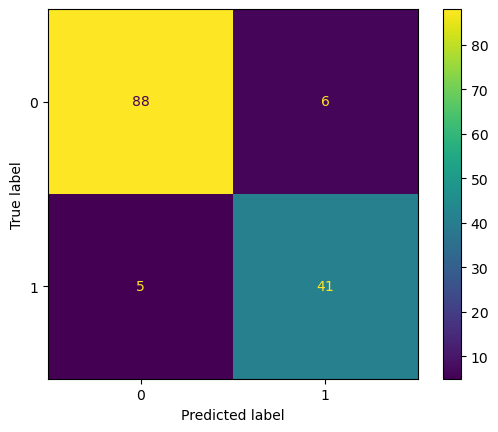

In [46]:
# On n'essaie que linéaire, beaucoup de variables catégorielles, les autres moins pertinentes
SVM_HAS = SVC(kernel="linear", max_iter=-1, random_state=42).fit(X_train_minimal, y_train_minimal["HasSleepDisorder"])
pred_train = SVM_HAS.predict(X_train_minimal)
pred_test = SVM_HAS.predict(X_test_minimal)
print(len(y_test_minimal[y_test_minimal["HasSleepDisorder"]==pred_test])/len(y_test_minimal))
cm = confusion_matrix(y_test_minimal["HasSleepDisorder"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
# On n'essaie que linéaire, beaucoup de variables catégorielles, les autres moins pertinentes#
SVM_MULTI = SVC(kernel="linear", max_iter=100000000, random_state=42).fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = SVM_MULTI.predict(X_train)
pred_test = SVM_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
TREE_MULTI = DecisionTreeClassifier(random_state=42).fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = TREE_MULTI.predict(X_train)
pred_test = TREE_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

0.9285714285714286


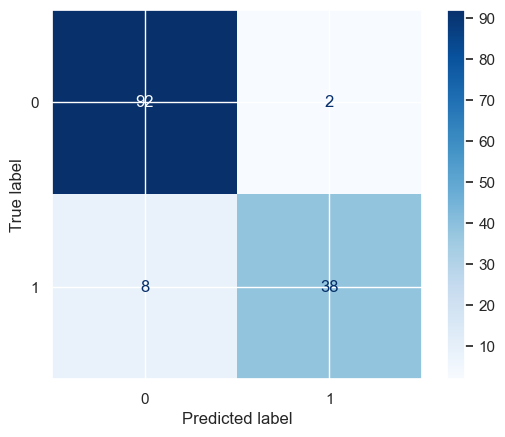

In [80]:
TREE_MULTI = DecisionTreeClassifier(random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"])
pred_train = TREE_MULTI.predict(X_train_all)
pred_test = TREE_MULTI.predict(X_test_all)
print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/ADD_CM1")

0.95


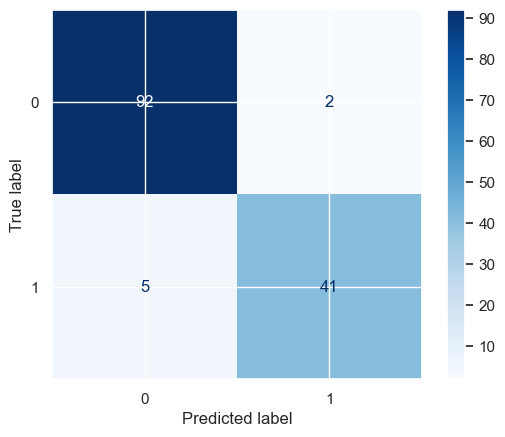

In [79]:
FOREST_MULTI = RandomForestClassifier(random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"])
pred_train = FOREST_MULTI.predict(X_train_all)
pred_test = FOREST_MULTI.predict(X_test_all)
print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/FA_CM1")

In [ ]:
BOOSTING_MULTI = GradientBoostingClassifier(random_state=42).fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = BOOSTING_MULTI.predict(X_train)
pred_test = BOOSTING_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
MLP_MULTI = MLPClassifier(hidden_layer_sizes=(16,), activation='relu', solver='adam', max_iter=1000, random_state=42)
MLP_MULTI.fit(X_train, y_train["SleepDisorderEncoded"])
pred_train = MLP_MULTI.predict(X_train)
pred_test = MLP_MULTI.predict(X_test)
print(len(y_test[y_test["SleepDisorderEncoded"]==pred_test])/len(y_test))
cm = confusion_matrix(y_test["SleepDisorderEncoded"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()